# Neural Network
This notebook implements the deep neural network model.

In [51]:
import os
import opendatasets as od
from pathlib import Path
import pickle 

import pandas as pd
import numpy as np

import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle

from src.utils import check_shape, missing_values_table
from src.preprocessing import clean_property_type, fill_missing_values, update_data, drop_columns, create_features

# 1. Data pre-processing

## Data import
The import reads the pre-processed, clean data output from [EDA_Preprocessing.ipynb](EDA_Preprocessing.ipynb).

In [52]:
df_train = pd.read_csv('clean_data/train_preproc.csv', index_col=0)
df_test = pd.read_csv('clean_data/test_preproc.csv', index_col=0)

Check that there are no missing values.

In [53]:
check_shape(df_train)
missing_values_table(df_train)

There are 20141 data points and 39 features
Your selected dataframe has 39 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [54]:
check_shape(df_test)
missing_values_table(df_test)

There are 7000 data points and 38 features
Your selected dataframe has 38 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [55]:
# Shuffle the data
df_train = shuffle(df_train)

y_train = df_train.pop('price')
X_train = df_train
X_test = df_test.copy()

In [56]:
y_train.head()

5209     1739800.0
20121     945000.0
12890    6998200.0
11885     420000.0
17269     524000.0
Name: price, dtype: float64

In [57]:
X_train.head()

,num_beds,num_baths,size_sqft,lat,lng,dist_meters_to_nearest_mrt,dist_meters_to_nearest_mall,dist_meters_to_nearest_commercial_centre,dist_meters_to_nearest_primary_school,dist_meters_to_nearest_secondary_school,...,property_type_townhouse,property_type_walk-up,nearest_mrt_line_cc,nearest_mrt_line_ce,nearest_mrt_line_cg,nearest_mrt_line_dt,nearest_mrt_line_ew,nearest_mrt_line_ne,nearest_mrt_line_ns,nearest_mrt_line_te
5209,1.0,1.0,527,1.294106,103.836735,729.462991,532.653630,1527.283142,1444.051119,866.888397,...,0,0,0,0,0,0,0,0,1,0
20121,4.0,2.0,1205,1.375179,103.900403,990.871511,790.564203,191.586627,378.780669,186.592110,...,0,0,0,0,0,0,0,1,0,0
12890,4.0,6.0,2067,1.294106,103.836735,729.462991,532.653630,1527.283142,1444.051119,866.888397,...,0,0,0,0,0,0,0,0,1,0
11885,2.0,2.0,731,1.383704,103.841160,473.372972,1402.790657,2550.309565,86.175063,254.028312,...,0,0,0,0,0,0,0,0,1,0
17269,3.0,2.0,1119,1.413534,103.836625,587.942291,732.369353,3390.724483,389.279990,297.406660,...,0,0,0,0,0,0,0,0,1,0


In [58]:
# Check at the bottom that all data types are float or int (no strings!)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20141 entries, 5209 to 6613
Data columns (total 38 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   num_beds                                  20141 non-null  float64
 1   num_baths                                 20141 non-null  float64
 2   size_sqft                                 20141 non-null  int64  
 3   lat                                       20141 non-null  float64
 4   lng                                       20141 non-null  float64
 5   dist_meters_to_nearest_mrt                20141 non-null  float64
 6   dist_meters_to_nearest_mall               20141 non-null  float64
 7   dist_meters_to_nearest_commercial_centre  20141 non-null  float64
 8   dist_meters_to_nearest_primary_school     20141 non-null  float64
 9   dist_meters_to_nearest_secondary_school   20141 non-null  float64
 10  active_years                    

In [59]:
y_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 20141 entries, 5209 to 6613
Series name: price
Non-Null Count  Dtype  
--------------  -----  
20141 non-null  float64
dtypes: float64(1)
memory usage: 314.7 KB


## Dimensionality Reduction

## Normalization
Normalization is carried out for features that are not one-hot encoded.

In [60]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer

cols = ['num_beds', 'num_baths', 'size_sqft', 'lat', 'lng',
        'dist_meters_to_nearest_mrt', 'dist_meters_to_nearest_mall',
        'dist_meters_to_nearest_commercial_centre',
        'dist_meters_to_nearest_primary_school',
        'dist_meters_to_nearest_secondary_school', 'active_years',
        'planning_area_mean']


scaler = StandardScaler()

ct = make_column_transformer(
    (scaler, cols),
    remainder='passthrough',
    verbose_feature_names_out=False
)

ct.fit(X_train)
X_train = ct.transform(X_train)


Apply the same normalizations to the test set.

In [61]:
X_test = ct.transform(X_test)

In [62]:
pd.DataFrame(X_train, columns=ct.get_feature_names_out())

,num_beds,num_baths,size_sqft,lat,lng,dist_meters_to_nearest_mrt,dist_meters_to_nearest_mall,dist_meters_to_nearest_commercial_centre,dist_meters_to_nearest_primary_school,dist_meters_to_nearest_secondary_school,...,property_type_townhouse,property_type_walk-up,nearest_mrt_line_cc,nearest_mrt_line_ce,nearest_mrt_line_cg,nearest_mrt_line_dt,nearest_mrt_line_ew,nearest_mrt_line_ne,nearest_mrt_line_ns,nearest_mrt_line_te
0,-1.654043,-1.116164,-0.638373,-0.991912,-0.118306,-0.105812,-0.493473,-0.368335,1.316096,0.074526,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.687018,-0.432508,-0.274111,0.757361,1.058662,0.365283,-0.006844,-1.628296,-0.673895,-1.030227,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.687018,2.302116,0.189008,-0.991912,-0.118306,-0.105812,-0.493473,-0.368335,1.316096,0.074526,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.873689,-0.432508,-0.528772,0.941305,-0.036510,-0.567322,1.148315,0.596685,-1.220500,-0.920715,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.093336,-0.432508,-0.320315,1.584944,-0.120340,-0.360852,-0.116646,1.389448,-0.654282,-0.850272,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20136,-0.873689,-0.432508,-0.580349,-0.030686,0.488623,-1.147733,-0.007941,-0.464055,0.007834,-0.170156,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
20137,0.687018,0.934804,0.003653,-0.942539,0.885091,1.032803,1.145125,0.476644,1.307794,0.321384,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20138,-0.093336,-0.432508,-0.256918,-0.087350,1.756712,-0.225538,1.252248,0.125875,-0.621632,-0.786754,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
20139,0.687018,1.618460,1.704082,-1.631670,-0.496542,-0.349888,-0.704913,0.898356,1.335107,1.162344,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Fitting the Neural Network Model


In [63]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.metrics import RootMeanSquaredError
from keras.callbacks import ReduceLROnPlateau

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.10.0
Num GPUs Available:  0


In [64]:
# define number of features
n_features = X_train.shape[1]


def build_and_compile_model():

    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(n_features,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='relu')
    ])

    model.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adam(0.01),
                  metrics=[RootMeanSquaredError()]
                  )
    return model


def plot_loss(history):
    # plot learning curves
    plt.title('Learning Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    plt.show()


In [65]:
# Build and compile the model
model = build_and_compile_model()
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                2496      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,721
Trainable params: 6,721
Non-trainable params: 0
_________________________________________________________________


In [66]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

# Train the model
X_train 
history = model.fit(X_train, y_train, epochs=200, batch_size=32,
                    verbose=2, validation_split=0.2, callbacks=[reduce_lr])


Epoch 1/200
504/504 - 1s - loss: 22208105676800.0000 - root_mean_squared_error: 4712547.5000 - val_loss: 13730293219328.0000 - val_root_mean_squared_error: 3705441.0000 - lr: 0.0100 - 912ms/epoch - 2ms/step
Epoch 2/200
504/504 - 0s - loss: 9997767409664.0000 - root_mean_squared_error: 3161924.7500 - val_loss: 11717767593984.0000 - val_root_mean_squared_error: 3423122.5000 - lr: 0.0100 - 381ms/epoch - 756us/step
Epoch 3/200
504/504 - 0s - loss: 9092784455680.0000 - root_mean_squared_error: 3015424.5000 - val_loss: 11053379354624.0000 - val_root_mean_squared_error: 3324662.2500 - lr: 0.0100 - 368ms/epoch - 730us/step
Epoch 4/200
504/504 - 0s - loss: 8624617816064.0000 - root_mean_squared_error: 2936770.0000 - val_loss: 10574071070720.0000 - val_root_mean_squared_error: 3251779.7500 - lr: 0.0100 - 398ms/epoch - 790us/step
Epoch 5/200
504/504 - 0s - loss: 8254304288768.0000 - root_mean_squared_error: 2873030.5000 - val_loss: 10171595096064.0000 - val_root_mean_squared_error: 3189293.7500 -

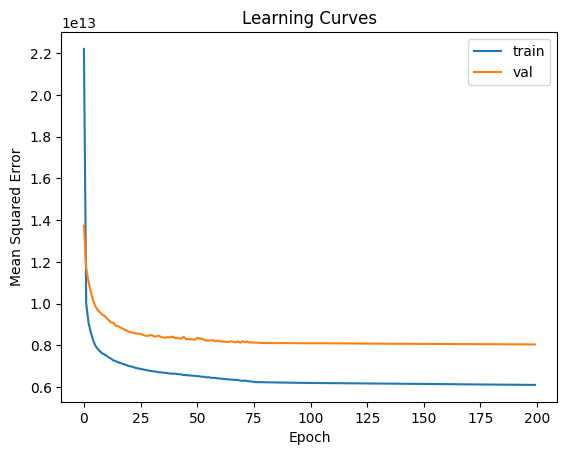

In [67]:
plot_loss(history)

## Predictions

In [68]:
df_submission = pd.read_csv("raw_data/example-submission.csv")
df_submission.shape

(7000, 2)

In [69]:
df_submission['Predicted'] = model.predict(X_test)

219/219 [==============================] - 0s 494us/step


In [70]:
df_submission.shape

(7000, 2)

In [71]:
df_submission.to_csv("models/neural_network_submission.csv", index=0)